In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, AvgPool2D, Flatten, Dense, Normalization, Input
from tensorflow.keras.layers import Conv2DTranspose

In [87]:
import os
import numpy as np
import cv2


In [88]:
# Initialize arrays
images = []
masks = []

image_dir = './Unet_Dataset/images/'
mask_dir = './Unet_Dataset/MASKS_BW/'

# Load images
for img_name in sorted(os.listdir(image_dir)):
    #print(img_name)
    img_path = os.path.join(image_dir, img_name)
    #print(img_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    images.append(img)

# Load masks
for mask_name in sorted(os.listdir(mask_dir)):
    mask_path = os.path.join(mask_dir, mask_name)
    #print(mask_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    masks.append(mask)


# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Reshape masks to add channel dimension
masks = np.expand_dims(masks, axis=-1)

print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')

Images shape: (150, 128, 128, 3)
Masks shape: (150, 128, 128, 1)


# Scale the arrays

In [15]:
images[0][0][0], masks[0][0][0]

(array([38, 52, 87], dtype=uint8), array([0], dtype=uint8))

In [16]:
images = images / 255.0
masks = masks / 255.0

In [17]:
images[0][0][0], masks[0][0][0]

(array([0.14901961, 0.20392157, 0.34117647]), array([0.]))

# Split the dataset into test and train

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (120, 128, 128, 3), (120, 128, 128, 1)
Test set shape: (30, 128, 128, 3), (30, 128, 128, 1)


# Build the model

In [31]:
def unet_model(input_size=(128,128,3)):
    inputL = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputL)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    # Bottleneck
    c5 = layers.Conv2D( 1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D( 1024, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7,c3])
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate( [u8, c2] )
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputL], outputs=[outputs])
    return model


model = unet_model()
model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_87[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ conv2d_88[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_89[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ conv2d_90[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_25… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_91[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 16, 16,    │          0 │ conv2d_92[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_26… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_93[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 8, 8, 512) │          0 │ conv2d_94[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_27… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_95[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 16, 16,    │  2,097,664 │ conv2d_96[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 109s 13s/step - accuracy: 0.7632 - loss: 0.6968 - val_accuracy: 0.8063 - val_loss: 0.5545
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 118s 15s/step - accuracy: 0.8313 - loss: 0.5230 - val_accuracy: 0.8063 - val_loss: 0.5057
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 110s 14s/step - accuracy: 0.8083 - loss: 0.5063 - val_accuracy: 0.8063 - val_loss: 0.4981
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 19s/step - accuracy: 0.8194 - loss: 0.4819 - val_accuracy: 0.8063 - val_loss: 0.5016
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 14s/step - accuracy: 0.8009 - loss: 0.4991 - val_accuracy: 0.8063 - val_loss: 0.4946


In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

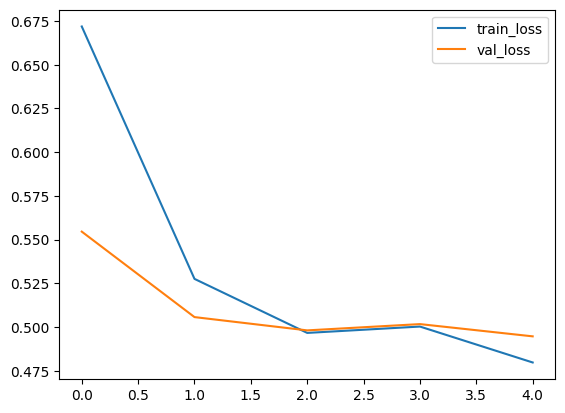

In [33]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

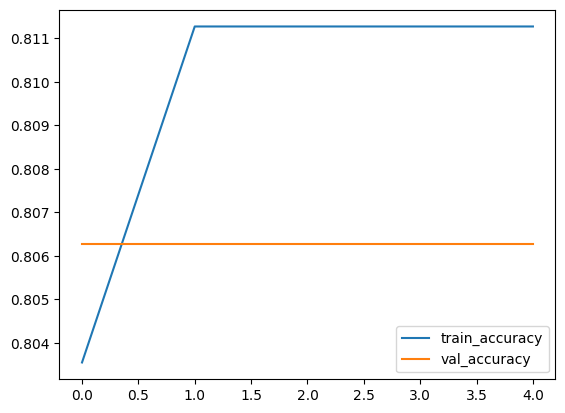

In [34]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [39]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8063 - loss: 0.4946


(0.4946460723876953, 0.8062703609466553)

In [40]:
history.history['accuracy']

[0.8035517334938049,
 0.8112696409225464,
 0.8112696409225464,
 0.8112696409225464,
 0.8112696409225464]

In [42]:
from tensorflow import keras

In [43]:
image_dir = './Unet_Dataset/images'
mask_dir =  './Unet_Dataset/MASKS_BW'

In [90]:
images = []
masks = []

i = 0
for img_name in sorted(os.listdir(image_dir)):
    img_fq_name = os.path.join(image_dir, img_name)
    img = cv2.imread(img_fq_name)
    img = cv2.resize(img, (128,128))
    images.append(img)

i = 0
for img_name in sorted(os.listdir(mask_dir)):
    img_path = os.path.join(mask_dir, img_name)
    #print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    masks.append(img)

images = np.array(images)
masks = np.array(masks)

# Reshape masks to add channel dimension
masks = np.expand_dims(masks, axis=-1)

images.shape, masks.shape

((150, 128, 128, 3), (150, 128, 128, 1))

In [92]:
images = images/255.0
masks = masks/255.0

In [93]:
images[0][0][0], masks[0][0][0]

(array([0.14901961, 0.20392157, 0.34117647]), array([0.]))

In [94]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(images, masks, test_size=0.2, random_state=43)
Xt_train.shape, Xt_test.shape, yt_train.shape, yt_test.shape

((120, 128, 128, 3), (30, 128, 128, 3), (120, 128, 128, 1), (30, 128, 128, 1))

In [95]:
from tensorflow.keras.optimizers import Adam

In [96]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as smodel

In [97]:
BACKBONE = 'resnet34'
preprocess_input = smodel.get_preprocessing(BACKBONE)

Xt_train = preprocess_input(Xt_train)
Xt_test = preprocess_input(Xt_test)

tl_model = smodel.Unet(BACKBONE, input_shape=(128,128,3), classes=1, activation='sigmoid')

tl_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

tl_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_102  │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_103  │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_104  │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_105  │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [98]:
Xt_train.shape, yt_train.shape, Xt_test.shape, yt_test.shape

((120, 128, 128, 3), (120, 128, 128, 1), (30, 128, 128, 3), (30, 128, 128, 1))

In [99]:
history = tl_model.fit(Xt_train, yt_train, epochs=5, batch_size=16, validation_data=(Xt_test, yt_test))

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7577 - loss: 0.5264 - val_accuracy: 0.7834 - val_loss: 0.5620
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8904 - loss: 0.3161 - val_accuracy: 0.7106 - val_loss: 0.6358
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8974 - loss: 0.2618 - val_accuracy: 0.5563 - val_loss: 0.7795
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9239 - loss: 0.1984 - val_accuracy: 0.2278 - val_loss: 5.4224
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9266 - loss: 0.1711 - val_accuracy: 0.4956 - val_loss: 5.6984


In [110]:
history.history['accuracy'], history.history['val_accuracy']

([0.7957667112350464,
  0.8964086174964905,
  0.9076411128044128,
  0.922851026058197,
  0.9264048337936401],
 [0.783447265625,
  0.7105570435523987,
  0.5563151240348816,
  0.22779540717601776,
  0.4955912232398987])

In [102]:
history.history

{'accuracy': [0.7957667112350464,
  0.8964086174964905,
  0.9076411128044128,
  0.922851026058197,
  0.9264048337936401],
 'loss': [0.47118377685546875,
  0.30227312445640564,
  0.24052391946315765,
  0.19624604284763336,
  0.17124277353286743],
 'val_accuracy': [0.783447265625,
  0.7105570435523987,
  0.5563151240348816,
  0.22779540717601776,
  0.4955912232398987],
 'val_loss': [0.5619743466377258,
  0.6357833743095398,
  0.7794700264930725,
  5.42239236831665,
  5.698447227478027]}

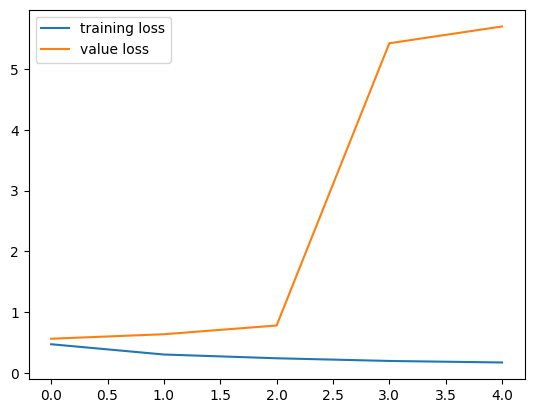

In [106]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='value loss')
plt.legend()
plt.show()

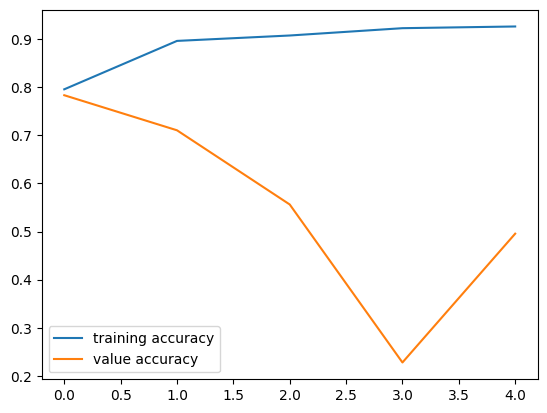

In [107]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='value accuracy')
plt.legend()
plt.show()

In [108]:
tl_loss, tl_accuracy = tl_model.evaluate(Xt_test, yt_test)
print("Transfer learning loss:", tl_loss)
print("Transfer learning accuracy:", tl_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.4956 - loss: 5.6984
Transfer learning loss: 5.698447227478027
Transfer learning accuracy: 0.4955912232398987
